In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
import random
import swifter
from sklearn.preprocessing import LabelEncoder
import math
import random
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import auc
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
hackathon_womens = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv")
hackathon_scouting = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv")
hackathon_nwhl = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_nwhl.csv")

In [4]:
start_data = hackathon_scouting.copy()
start_data.shape

(75873, 21)

In [5]:
data = start_data.copy()
data.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN
1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74.0,35.0
3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,Erie Otters,Hayden Fowler,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94.0,46.0


### Data Setup

#### Create a column specifically for whether a goal is scored

In [6]:
data['goalScored'] = 0
data.loc[data.Event == 'Goal', 'goalScored'] = 1
data['shotAttempted'] = 0
data.loc[data.Event.isin(['Goal', 'Shot']), 'shotAttempted'] = 1
data.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,goalScored,shotAttempted
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN,0,0
1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74.0,35.0,0,0
3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,Erie Otters,Hayden Fowler,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94.0,46.0,0,0


#### Determine what the next goal value is
-1 = Opponent Goal
0 = No Goal
1 = Goal

In [8]:
data_array = np.array(data)

In [9]:
next_score = 0
next_score_team = ''
next_shot = 0
next_shot_team = ''
period = None
prevPeriod = None
game = None
prevGame = None
next_scored = [0 for i in range(len(data_array))]
next_shots = [0 for i in range(len(data_array))]

for i, row in zip(range(len(data_array)-1, -1, -1), reversed(data_array)):
    period = row[3]
    game = row[0] + row[1] + row[2]
    goalScored = row[21]
    shotTaken = row[22]
    posTeam = row[9]
    if (prevPeriod == None):
        prevPeriod = period
    elif (period != prevPeriod):
        prevPeriod = period
        next_score = 0
        next_score_team = ''
        next_shot = 0
        next_shot_team = ''
    if (prevGame == None):
        prevGame == game
    elif (game != prevGame):
        prevGame = game
        next_score = 0
        next_score_team = ''
        next_shot = 0
        next_shot_team = ''
    if(goalScored == 1):
        next_score = goalScored
        next_score_team = row[9]
        next_scored[i] = 1
    else:
        next_scored[i] = next_score * (int(posTeam == next_score_team) * 2 - 1)
    if(shotTaken == 1):
        next_shot = shotTaken
        next_shot_team = row[9]
        next_shots[i] = 1
    else:
        next_shots[i] = next_shot * (int(posTeam == next_shot_team) * 2 - 1)

In [10]:
data['nextScore'] = next_scored
data['nextShot'] = next_shots

#### Create some new columns
pos/defTeamScore - Score based on who possesses the ball  
newEvents - Make the Goal Event the same as a Shot  
newClock - Normalized, numeric value of the game clock  
x/y - Normalized value of the coordinate  

In [12]:
data['posTeamScore'] = np.where(data.Team == data['Home Team'], 
                                data['Home Team Goals'], data['Away Team Goals'])
data['defTeamScore'] = np.where(data.Team != data['Home Team'], 
                                data['Home Team Goals'], data['Away Team Goals'])
data['newEvents'] = np.where(data.Event == "Goal", 'Shot', data.Event)
data['newClock'] = np.array([int(i[0])*60 + int(i[1]) for i in data.Clock.str.split(':')]) / 1200
data['x'] = data['X Coordinate'] / 200
data['y'] = data['Y Coordinate'] / 85

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import statsmodels.formula.api as smf

### Some functions to make the training process easier

In [14]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [841]:
def createTables(err, calData, classes, importances=[], cols=[], saveFig=''):
    def checkImportance(importances, cols):
        if (len(importances) > 0) & (len(cols) > 0):
            return True
        return False
    
    numPlots = len(classes)
    if checkImportance(importances, cols):
        numPlots +=1
    fig, ax = plt.subplots(1, numPlots, figsize=(40, 10))
    
    if checkImportance(importances, cols):
        ax[0].barh(cols, importances)
    for i in range(0, len(classes)):
        index = i
        if checkImportance(importances, cols):
            index += 1
        sizes = 100
        if('sizes' in calData.columns):
            sizes = calData['sizes']
        y2s = lowess(calData[calData.variable == classes[i]].corr_prob, calData[calData.variable == classes[i]].value)[:,1]
        title = 'No Goal'
        if classes[i] == -1:
            title = 'Opponent Goal'
        elif classes[i] == 1:
            title = 'Goal'
        ax[index].set_title(title, fontsize=40)
        ax[index].scatter(calData[calData.variable == classes[i]].value, calData[calData.variable == classes[i]].corr_prob, s=sizes[calData.variable == classes[i]])
        ax[index].plot([0, 1], [0, 1], linestyle='--', c='b')
        ax[index].plot(calData[calData.variable == classes[i]].value, y2s, c='k', linewidth=8, alpha=0.5)
    fig.text(0.45, 0.05, 'Predicted Next Goal Probability', ha='center', va='center', fontsize=40)
    fig.text(0.01, 0.55, 'Actual Next Goal Probability', ha='center', va='center', rotation='vertical', fontsize=40)
    if(saveFig):
        plt.gcf().subplots_adjust(left=0.04, bottom=0.15)
        plt.savefig(saveFig, dpi=300)
    plt.show()

In [16]:
def calcAccuracy(phat, classes, ytest):
    accuracyTable = pd.DataFrame(phat, columns=classes)
    accuracyTable['actual'] = ytest.reset_index()[] 
    temp = pd.melt(accuracyTable, id_vars=["actual"], value_vars=classes)
    temp["correct"] = (temp["actual"] == temp["variable"]).astype(int)
    temp["value"] = (temp["value"] / .05).round() * 0.05
    n_corr = temp.groupby(["variable", "value"])["correct"].sum().reset_index()['correct']
    n_plays = temp.groupby(["variable", "value"])["correct"].count().reset_index()['correct']
    temp = temp.groupby(["variable", "value"])["correct"].mean().reset_index()
    temp["correct1"] = n_corr
    temp["plays"] = n_plays
    temp["corr_prob"] = n_corr / n_plays
    temp["diff"] = np.abs(temp.value - temp.corr_prob)
    find_err = temp.groupby(["variable"]).apply(wavg, "diff", "plays").reset_index()
    find_err = find_err.rename(columns={0:"weighted_avg_diff"})
    find_err["n_scoring_outcomes"] = temp.groupby(["variable"])["correct1"].sum().reset_index()["correct1"]
    err = np.average(find_err["weighted_avg_diff"], weights=find_err["n_scoring_outcomes"])
    return err, temp

In [165]:
from sklearn.preprocessing import LabelEncoder
forRegr = data.copy()
lb = LabelEncoder()
forRegr['newEvents'] = lb.fit_transform(forRegr['newEvents'])
forRegr['events'] = lb.fit_transform(forRegr['Event'])
forRegr['fiveOnFive'] = (forRegr['Home Team Skaters'] == forRegr['Away Team Skaters'])

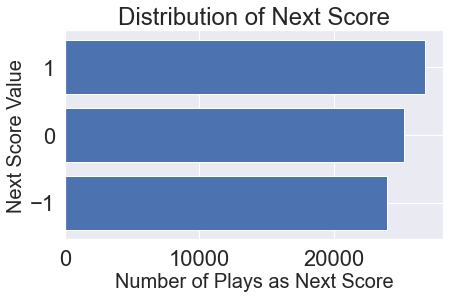

In [809]:
fig, distAx = plt.subplots(figsize=(7, 5))
distAx.barh(forRegr.nextScore.value_counts().index, forRegr.nextScore.value_counts())
distAx.set_yticks([-1, 0, 1])
distAx.set_xlabel('Number of Plays as Next Score', fontsize=20)
distAx.set_ylabel('Next Score Value', fontsize=20)
distAx.set_title('Distribution of Next Score')
plt.gcf().subplots_adjust(left=0.15, bottom=0.3)
plt.savefig('Distribution of Next Score')

In [167]:
def randomGridCV(hyperParams, XInput, yInput, searches):
    finalErrors = {}
    for i in range(0, searches):
        params = {
            'nestim': 100,
            'maxDepth': None,
            'crit': 'gini',
            'maxFeatures': 'auto',
            'mSS': 2,
        }
        for param in hyperParams:
            randInt = random.randint(0, len(hyperParams[param])-1)
            vals = hyperParams[param]
            params[param] = vals[randInt]
        model = RandomForestClassifier(random_state=2013, n_estimators=params['nestim'], max_depth=params['maxDepth'], criterion=params['crit'], 
                                           max_features=params['maxFeatures'], min_samples_split=params['mSS'], n_jobs=-1)
        errs = performCV(XInput, yInput, model, 5, 'nextScore')
        err = sum(errs) / len(errs)
        finalErrors[','.join([str(x) for x in params.values()])] = err
    return finalErrors
def performCV(XInput, yInput, model, iters, yLabel):
    errors = []
    for i in range(0, iters):
        modelToUse = model
        Xtrain, Xval, ytrain, yval = train_test_split(XInput,
                                                        yInput, test_size=0.2)
        model.fit(Xtrain, ytrain)
        phat = model.predict_proba(Xval)
        err, calibData = calcAccuracy(phat, model.classes_, yval, yLabel)
        errors.append(err)
    return errors

In [188]:
Xtrain, Xtest, ytrain, ytest = train_test_split(forRegr[['newEvents', 'x', 'y', 'Period', 'posTeamScore', 'defTeamScore', 'fiveOnFive']],
                                                    forRegr['nextScore'], test_size=0.2)

In [189]:
forest = RandomForestClassifier(random_state=2013, n_jobs=-1)
cvErrors = performCV(Xtrain, ytrain, forest, 5, 'nextScore')
print("CV Err:", sum(cvErrors) / len(cvErrors))

CV Err: 0.08323189186291727


### Hyper Parameter Tuning

#### Do a random grid search with CV

In [192]:
%%time
hyperParams = {
    'nestim': [50, 60, 70, 90, 100, 250],
    'maxDepth': [5, 10, 15],
    'crit': ['gini', 'entropy'],
    'maxFeatures': ['sqrt', 'log2'],
    'mSS': [2, 3, 4, 5, 7, 10]
}
rgErrs = randomGridCV(hyperParams, Xtrain, ytrain, 232)
print("Best features:", min(rgErrs, key=rgErrs.get), "Calib Error:", rgErrs[min(rgErrs, key=rgErrs.get)])

Best features: 60,15,gini,log2,2 Calib Error: 0.01945812751561274
Wall time: 8min 34s


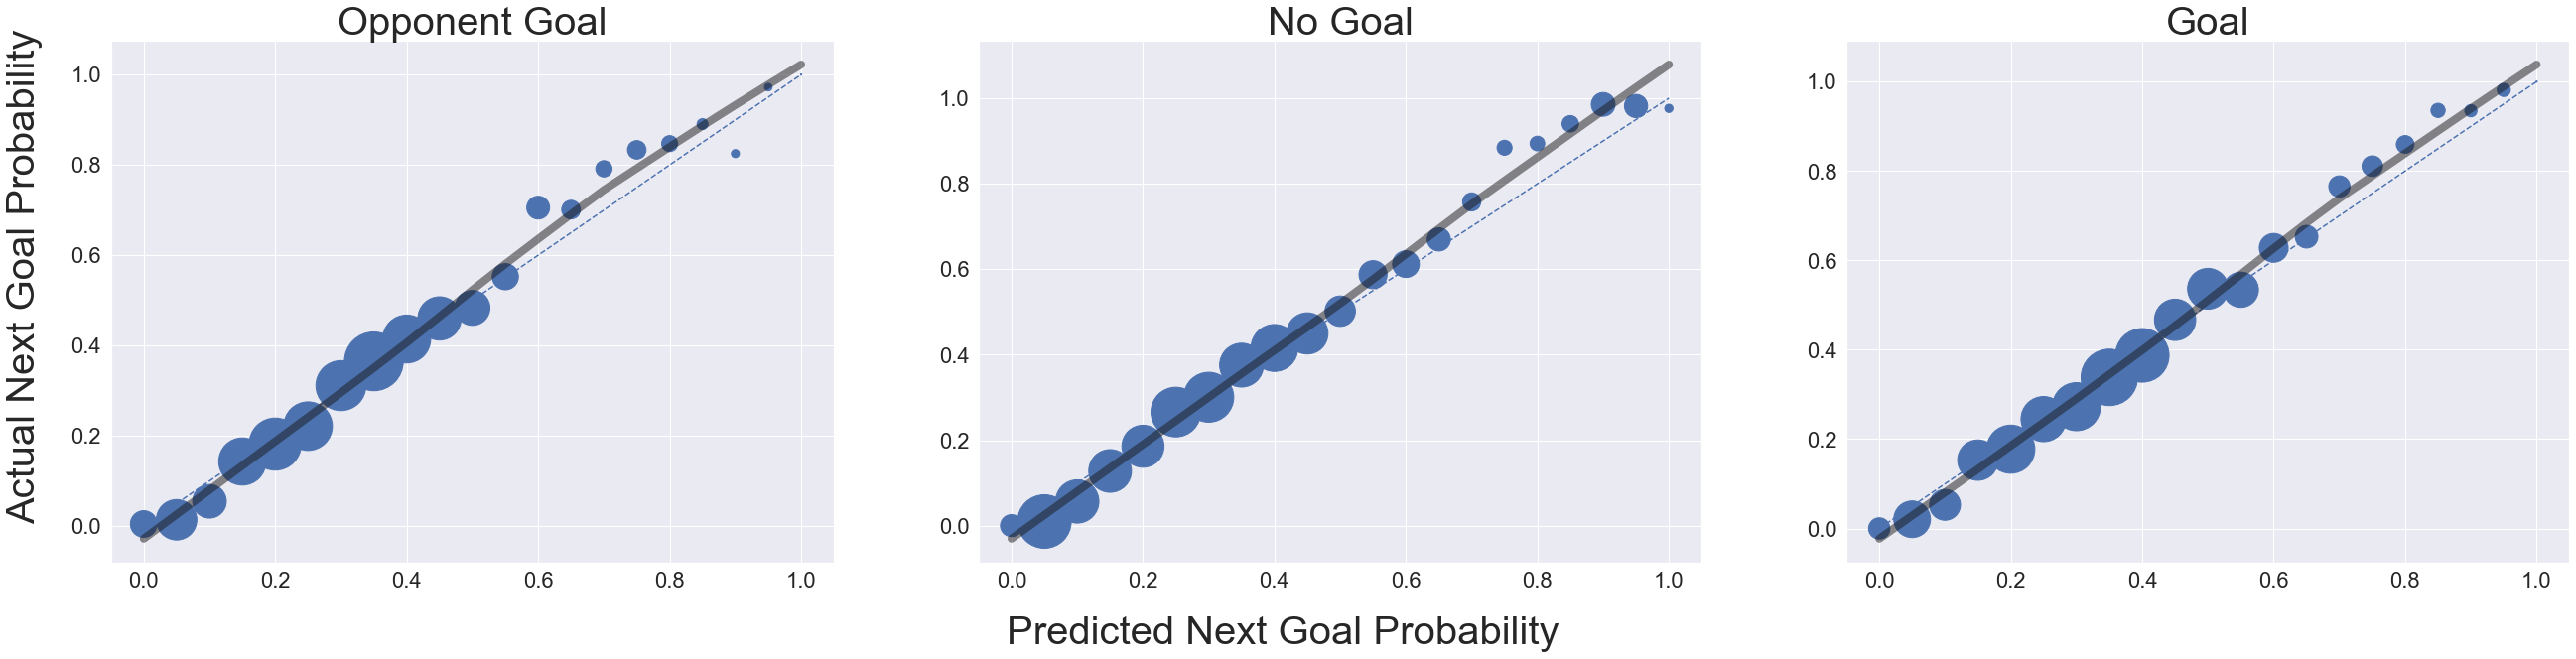

Final Calib Error: 0.022439733694486878


In [842]:
finalCalibForest = RandomForestClassifier(random_state=2013, n_estimators=60, max_depth=15, criterion='gini', 
                                       max_features='log2', min_samples_split=2, n_jobs=-1)
finalCalibForest.fit(Xtrain, ytrain)
phat = finalCalibForest.predict_proba(Xtest)
err, calibData = calcAccuracy(phat, finalCalibForest.classes_, ytest, 'nextScore')
calibData['sizes'] = calibData.plays.values / calibData.plays.mean() * 1200
createTables(err, calibData, finalCalibForest.classes_, [], [], 'EG Calibration')
print('Final Calib Error:', err)

### Predict on Final Model for all Data

In [194]:
finalEgaX = forRegr[['newEvents', 'x', 'y', 'Period', 'posTeamScore', 'defTeamScore', 'fiveOnFive']]
finalEgaY = forRegr['nextScore']

In [198]:
phat = finalCalibForest.predict_proba(finalEgaX)
#err, calibData = calcAccuracy(phat, finalCalibForest.classes_, finalEgaY, 'nextScore')
#calibData['sizes'] = calibData.plays.values / calibData.plays.mean() * 200
#createTables(err, calibData, finalCalibForest.classes_, [], [], '')
#print('Final Calib Error:', err)

In [199]:
pickle.dump(finalCalibForest, open('finalEGAModel', 'wb'))

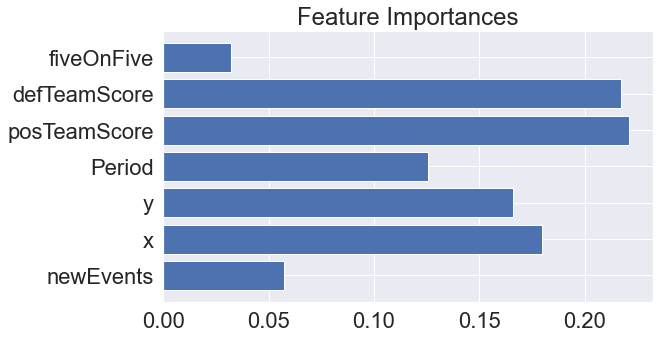

In [812]:
fig, fIx = plt.subplots(figsize=(10,5))
fIx.barh(finalEgaX.columns, egaModel.feature_importances_)
fIx.set_title('Feature Importances')
plt.gcf().subplots_adjust(left=0.22)
plt.savefig('Final Importances')

In [201]:
egVals = phat[:, 0] * egaModel.classes_[0] + phat[:, 1] * egaModel.classes_[1] + phat[:, 2] * egaModel.classes_[2]

In [202]:
afterData = data.copy()
afterData['EG'] = np.where(afterData.Event == 'Goal', 1, egVals)

### Create EPA value

In [203]:
afterdata_array = np.array(afterData)
EGloc = np.where(afterData.columns == 'EG')[0][0]
goalScore = False
prevGame = None
prevPoss = None
prevPeriod = None
prevEG = 0
egaArr = np.zeros(len(afterdata_array))

for i, row in enumerate(afterdata_array):
    currGame = row[0]
    currPeriod = row[3]
    currPoss = row[9]
    currEG = row[EGloc]
    
    if(currGame != prevGame) or (currPeriod != prevPeriod):
        prevEG = 0
        prevGame = currGame
        prevPeriod = currPeriod
    if goalScore:
        prevEG = 0
        goalScore = False
    if row[11] == 'Goal':
        goalScore = True
    
    if (currPoss != prevPoss):
        prevPoss = currPoss
        prevEG *= -1
    ega = currEG - prevEG
    prevEG = currEG
    egaArr[i] = ega
afterData['Ega'] = egaArr

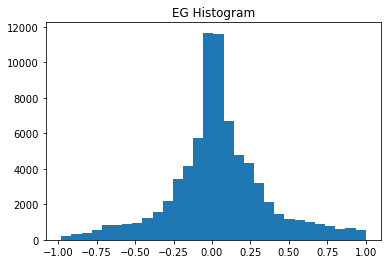

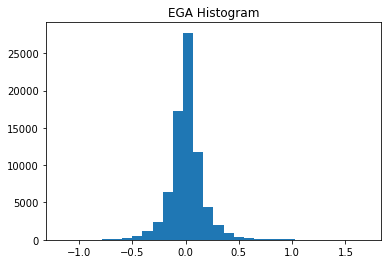

In [204]:
plt.hist(afterData['EG'], bins=30)
plt.title('EG Histogram')
plt.show()
plt.hist(afterData['Ega'], bins=30)
plt.title('EGA Histogram')
plt.show()

### EGA Analysis

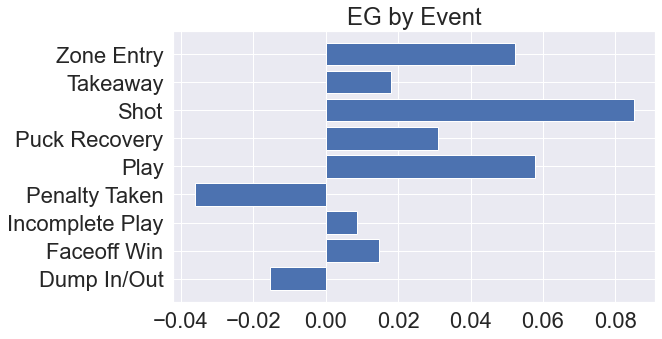

In [814]:
egEvent = afterData[~afterData.Event.isin(['Goal'])].groupby(['Event'])['EG'].mean().reset_index()
fig, egAx = plt.subplots(figsize=(10,5))
egAx.barh(egEvent.Event, egEvent.EG)
egAx.set_title('EG by Event')
plt.gcf().subplots_adjust(left=0.23)
plt.savefig('EG by Event')
plt.show()

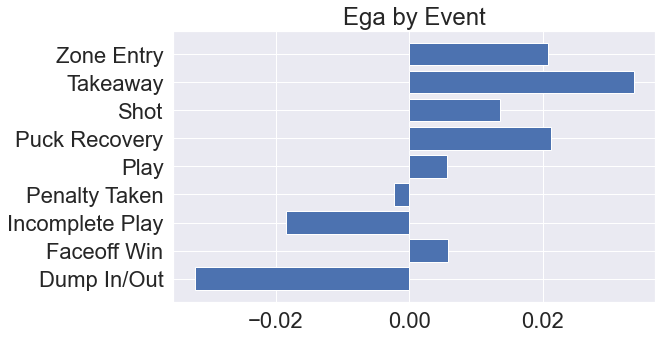

In [815]:
egaEvent = afterData[~afterData.Event.isin(['Goal'])].groupby(['Event'])['Ega'].mean().reset_index()
fig, egaAx = plt.subplots(figsize=(10,5))
egaAx.barh(egaEvent.Event, egaEvent.Ega)
egaAx.set_title('Ega by Event')
plt.gcf().subplots_adjust(left=0.23)
plt.savefig('Ega by Event')
plt.show()

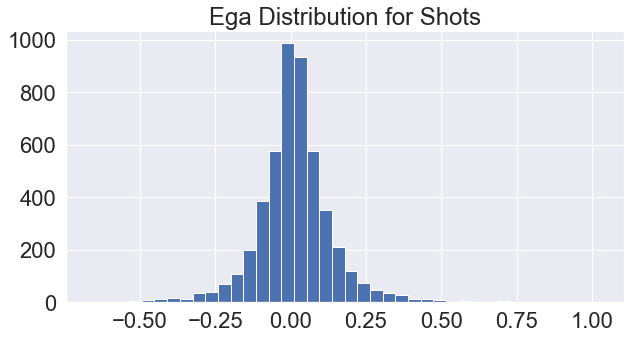

In [858]:
fig, egaShotAx = plt.subplots(figsize=(10,5))
egaShotAx.hist(afterData[afterData.Event.isin(['Shot'])].Ega, bins=40)
egaShotAx.set_title('Ega Distribution for Shots')
plt.savefig('Ega Distribution for Shots')
plt.show()

In [210]:
egaPlayerGame = afterData.groupby(['Player', 'Team', 'game_date'])['Ega'].mean().reset_index()
egaPlayerGameTemp = afterData.groupby(['Player', 'Team'])['Ega'].mean().reset_index()
egaPlayerGameTemp.columns = ['Player', 'Team', 'AvgEga']
egaPlayerGame = egaPlayerGame.merge(egaPlayerGameTemp, on=['Player', 'Team'], how='left')
egaPlayerGame = egaPlayerGame.sort_values(by='AvgEga', ascending=True)

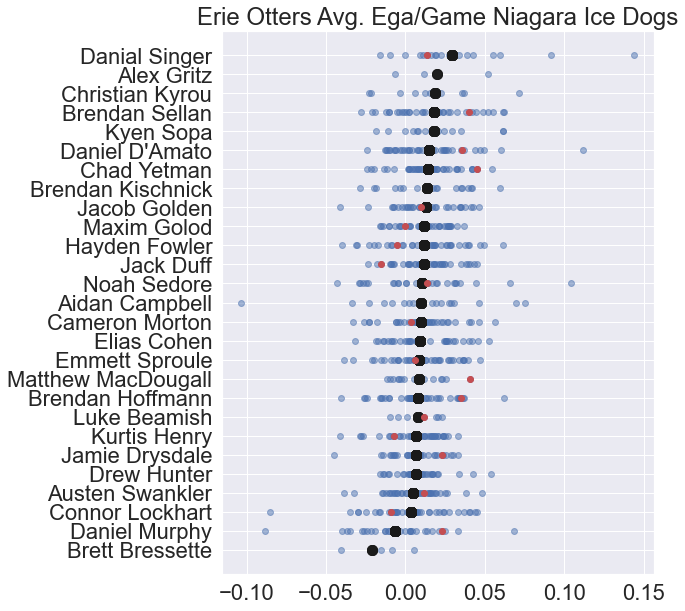

In [870]:
egaPlayerGamePlot = egaPlayerGame[egaPlayerGame.Team == 'Erie Otters']
fig2, ax2 = plt.subplots(figsize=(10, 10))
ax2.scatter(egaPlayerGamePlot.Ega, egaPlayerGamePlot.Player, alpha=0.5)
ax2.scatter(egaPlayerGamePlot.AvgEga, egaPlayerGamePlot.Player, s=100, c='k', alpha=0.7)
ax2.scatter(egaPlayerGamePlot[egaPlayerGamePlot.game_date == '2019-10-17'].Ega, egaPlayerGamePlot[egaPlayerGamePlot.game_date == '2019-10-17'].Player, c='r', alpha=1)
ax2.set_title('Erie Otters Avg. Ega/Game Niagara Ice Dogs')
plt.gcf().subplots_adjust(left=0.3)
plt.savefig('Erie Otters Ega per Game Niagara Ice Dogs')
plt.show()

In [232]:
!pip install dataframe_image

In [272]:
import dataframe_image as dfi
oct17th = afterData[(afterData.Player.isin(['Jack Duff', 'Chad Yetman'])) & (afterData.game_date == '2019-10-17')].groupby(['Player', 'Event']).agg({'Ega':['sum', 'mean', 'count']})
oct17th.columns = ['Cum Epa', 'Avg. Epa', '# of Plays']
dfi.export(oct17th, 'oct17th.png')

In [263]:
egaPlayerGame2 = afterData.groupby(['Player', 'Team', 'game_date', 'Event']).agg({'Ega':['sum', 'count']}).reset_index()
egaPlayerGame2.columns = ['Player', 'Team', 'game_date', 'Event', 'egaSum', 'events']
egaPlayerGame2['weightedEgaEvent'] = egaPlayerGame2['egaSum'] * egaPlayerGame2['events']
egaPlayerGame2 = egaPlayerGame2.groupby(['Player', 'Team', 'game_date'])[['egaSum', 'weightedEgaEvent', 'events']].sum().reset_index()
egaPlayerGame2.columns = ['Player', 'Team', 'game_date', 'cumEga', 'CumWeightedEgaGame', 'totalEvents']
egaPlayerGame2['AvgWeightedEgaGame'] = egaPlayerGame2['CumWeightedEgaGame'] / egaPlayerGame2['totalEvents']
egaPlayerGameTemp2 = egaPlayerGame2.groupby(['Player', 'Team'])['AvgWeightedEgaGame'].mean().reset_index()
egaPlayerGameTemp2.columns = ['Player', 'Team', 'AvgWeightedEpa']
egaPlayerGame2 = egaPlayerGame2.merge(egaPlayerGameTemp2, on=['Player', 'Team'], how='left')
egaPlayerGame2 = egaPlayerGame2.sort_values(by='AvgWeightedEpa', ascending=True)
egaPlayerGame2.sample(3)

,Player,Team,game_date,cumEga,CumWeightedEgaGame,totalEvents,AvgWeightedEgaGame,AvgWeightedEpa
850,Jack Duff,Erie Otters,2020-03-08,-0.439727,-4.534243,57,-0.079548,0.250949
358,Chase Stillman,Sudbury Wolves,2019-09-20,0.512166,8.619680,46,0.187384,0.331901
451,Dakota Betts,Niagara Ice Dogs,2019-10-17,-0.581440,-5.027873,27,-0.186218,0.041883


In [279]:
egaPlayerGamePlt2[egaPlayerGamePlt2.AvgWeightedEgaGame == egaPlayerGamePlt2.AvgWeightedEgaGame.max()]

,Player,Team,game_date,cumEga,CumWeightedEgaGame,totalEvents,AvgWeightedEgaGame,AvgWeightedEpa
897,Jacob Golden,Erie Otters,2020-03-07,2.954156,94.154829,79,1.191833,0.238654


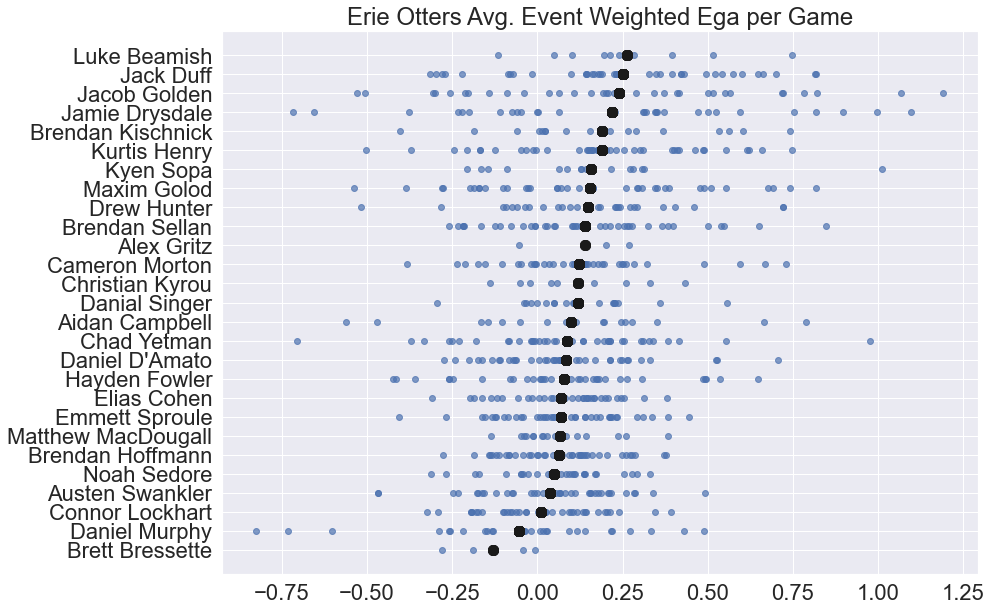

In [862]:
egaPlayerGamePlt2 = egaPlayerGame2[egaPlayerGame2.Team == 'Erie Otters'].copy()
fig3, ax3 = plt.subplots(figsize=(15,10))
ax3.scatter(egaPlayerGamePlt2.AvgWeightedEgaGame, egaPlayerGamePlt2.Player, alpha=0.7)
ax3.scatter(egaPlayerGamePlt2.AvgWeightedEpa, egaPlayerGamePlt2.Player, s=100, c='k')
#ax3.scatter(egaPlayerGamePlt2[egaPlayerGamePlt2.game_date == '2019-10-17'].AvgWeightedEgaGame, egaPlayerGamePlt2[egaPlayerGamePlt2.game_date == '2019-10-17'].Player, c='r')
ax3.set_title('Erie Otters Avg. Event Weighted Ega per Game')
plt.gcf().subplots_adjust(left=0.2)
plt.savefig('Erie Otters Weighted Ega per Game')
plt.show()

In [282]:
egaPlayerGame3 = afterData.groupby(['Player', 'Team', 'game_date', 'Event']).agg({'Ega':['sum', 'count']}).reset_index()
egaPlayerGame3.columns = ['Player', 'Team', 'game_date', 'Event', 'egaSum', 'events']
egaPlayerGame3['weightedEgaEvent'] = egaPlayerGame3['egaSum'] * egaPlayerGame3['events']
oct17th2 = egaPlayerGame3[(egaPlayerGame3.Player == 'Jacob Golden') & (egaPlayerGame3.game_date == '2020-03-07')]
oct17th2
#dfi.export(oct17th2, 'oct17th2.png')

,Player,Team,game_date,Event,egaSum,events,weightedEgaEvent
6386,Jacob Golden,Erie Otters,2020-03-07,Dump In/Out,0.008117,3,0.024352
6387,Jacob Golden,Erie Otters,2020-03-07,Incomplete Play,-0.245532,3,-0.736596
6388,Jacob Golden,Erie Otters,2020-03-07,Penalty Taken,-0.049389,1,-0.049389
6389,Jacob Golden,Erie Otters,2020-03-07,Play,2.401617,35,84.056597
6390,Jacob Golden,Erie Otters,2020-03-07,Puck Recovery,0.295900,29,8.581106
6391,Jacob Golden,Erie Otters,2020-03-07,Shot,0.071936,2,0.143871
6392,Jacob Golden,Erie Otters,2020-03-07,Takeaway,0.055662,1,0.055662
6393,Jacob Golden,Erie Otters,2020-03-07,Zone Entry,0.415845,5,2.079227


In [296]:
egaPlayerGame4 = afterData.groupby(['Player', 'Team', 'Event']).agg({'Ega':['sum', 'count']}).reset_index()
egaPlayerGame4.columns = ['Player', 'Team', 'Event', 'egaSum', 'events']
egaPlayerGame4['weightedEgaEvent'] = egaPlayerGame4['egaSum'] * egaPlayerGame4['events']
egaPlayerGameTemp4 = egaPlayerGame4.groupby(['Player', 'Team'])[['weightedEgaEvent', 'egaSum', 'events']].sum().reset_index()
egaPlayerGameTemp4['WeightedEgaEventSeason'] = egaPlayerGameTemp4['weightedEgaEvent'] / egaPlayerGameTemp4['events']
egaPlayerGameTemp4['EgaEventSeason'] = egaPlayerGameTemp4['egaSum'] / egaPlayerGameTemp4['events']
egaPlayerGameTemp4

,Player,Team,weightedEgaEvent,egaSum,events,WeightedEgaEventSeason,EgaEventSeason
0,A.J. Cook,Niagara Ice Dogs,72.557486,3.475424,99,0.732904,0.035105
1,Adam McMaster,Owen Sound Attack,6.913258,0.528503,139,0.049736,0.003802
2,Adam Samuelsson,Sudbury Wolves,41.566103,1.310856,49,0.848288,0.026752
3,Adam Varga,Mississauga Steelheads,7.317970,0.693195,44,0.166318,0.015754
4,Adam Varga,Ottawa 67's,16.333412,1.532592,58,0.281611,0.026424
...,...,...,...,...,...,...,...
421,Yevgeni Oksentyuk,Flint Firebirds,-36.339929,-0.639725,140,-0.259571,-0.004569
422,Zachary Roy,Hamilton Bulldogs,-8.922972,-0.524451,35,-0.254942,-0.014984
423,Zack Terry,Guelph Storm,-5.264265,-1.673439,126,-0.041780,-0.013281
424,Zack Trott,Sault Ste. Marie Greyhounds,42.621432,2.553599,71,0.600302,0.035966


In [307]:
afterData.groupby('Player')['goalScored'].sum().reset_index().sort_values(by='goalScored', ascending=False)

,Player,goalScored
72,Chad Yetman,29
294,Maxim Golod,15
103,Daniel D'Amato,13
159,Hayden Fowler,12
29,Austen Swankler,11
...,...,...
64,Cameron Peters,0
65,Cameron Snow,0
66,Cameron Supryka,0
206,Joe Ranger,0


<BarContainer object of 27 artists>

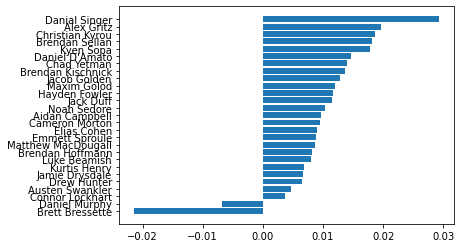

In [303]:
egaPlayerGamePlot4 = egaPlayerGameTemp4[egaPlayerGameTemp4.Team == 'Erie Otters'].sort_values(by='EgaEventSeason')
plt.barh(egaPlayerGamePlot4.Player, egaPlayerGamePlot4.EgaEventSeason)

In [308]:
import seaborn as sns

In [326]:
def createHockeyBackground(data, bins, events1, field='Event', events2=None):
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.set_ylim(0, 85)
    ax.set_xlim(0, 200)
    ax.axvline(100, c='r')
    ax.axvline(75, c='b', linewidth=4)
    ax.axvline(125, c='b', linewidth=4)
    ax.plot([11, 11], [39.5, 45.5], c='r', linewidth=4)
    ax.plot([189, 189], [39.5, 45.5], c='r', linewidth=4)
    ax.plot([0, 200, 200, 0, 0], [0, 0, 85, 85, 0], c='k')
    h1 = ax.hist2d(data.loc[data[field].isin(events1), 'X Coordinate'], data.loc[data[field].isin(events1), 'Y Coordinate'], range=[[0, 200], [0, 85]], cmin=1, bins=[40, 17])
    if(events2):
        h2 = ax.hist2d(200 - data.loc[data[field].isin(events2), 'X Coordinate'], data.loc[data[field].isin(events2), 'Y Coordinate'], range=[[0, 200], [0, 85]], bins=[40, 17], cmap='copper', cmin=1)
    fig.colorbar(h1[3], ax=ax)
    plt.colorbar(h2[3], ax=[ax], location = 'left')
    plt.axis('off')
    plt.show()

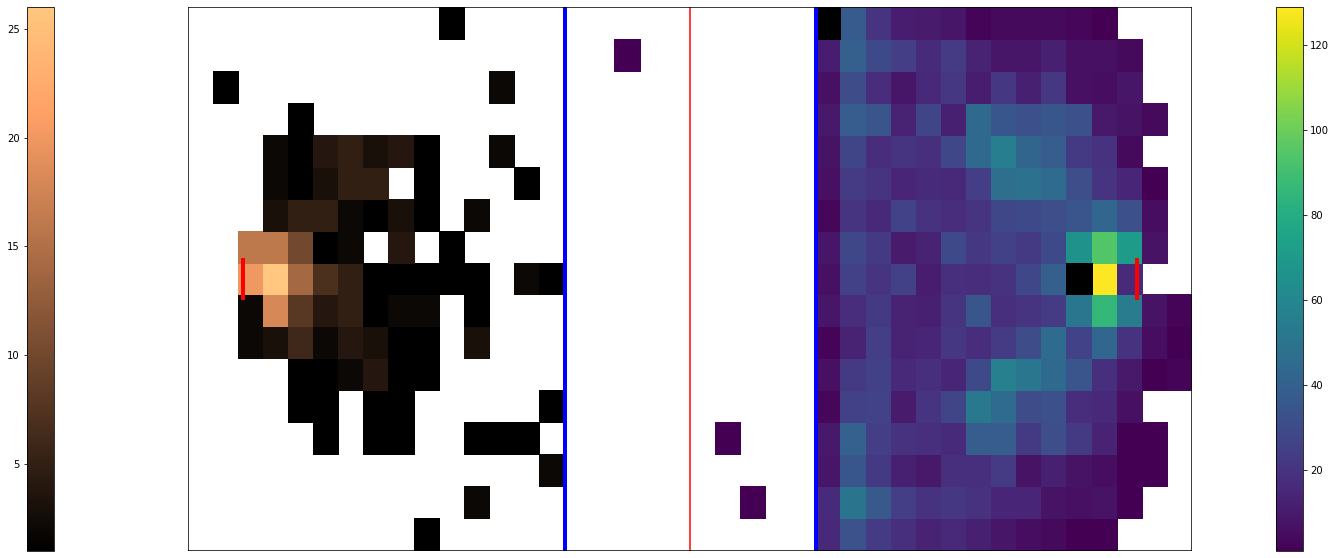

In [327]:
createHockeyBackground(data, [40, 17], ['Shot'], 'Event', ['Goal'])

In [720]:
afterData[afterData.Player.isin(['Connor Lockhart'])].groupby('Event').agg({'Ega':['count', 'mean']})

Ega          
                count      mean
Event                          
Dump In/Out       110 -0.029269
Faceoff Win        92 -0.024054
Goal                5  0.663258
Incomplete Play   193 -0.031402
Penalty Taken       8  0.001819
Play              438 -0.001131
Puck Recovery     347  0.017800
Shot               92  0.011764
Takeaway           68  0.055088
Zone Entry        144  0.021689

In [756]:
binnedAfterData = afterData[afterData.Player.isin(['Noah Sedore']) & (afterData.Event.isin(['Play', 'Incomplete Play']))].copy()
binnedAfterData['X Coordinate'] = round(binnedAfterData['X Coordinate'] / 40) * 40
binnedAfterData['Y Coordinate'] = round(binnedAfterData['Y Coordinate'] / 17) * 17
binnedAfterData = binnedAfterData.groupby(['X Coordinate', 'Y Coordinate']).agg({'Ega':['sum', 'mean', 'count']}).reset_index()
binnedAfterData.columns = ['X Coordinate', 'Y Coordinate', 'EgaSum','EgaMean', 'EgaCount']
binnedAfterData['WeightedEga'] = binnedAfterData['EgaSum'] * binnedAfterData['EgaCount'] / binnedAfterData['EgaCount'].sum()
#binnedAfterData = binnedAfterData[binnedAfterData['EgaCount'] > 4]s

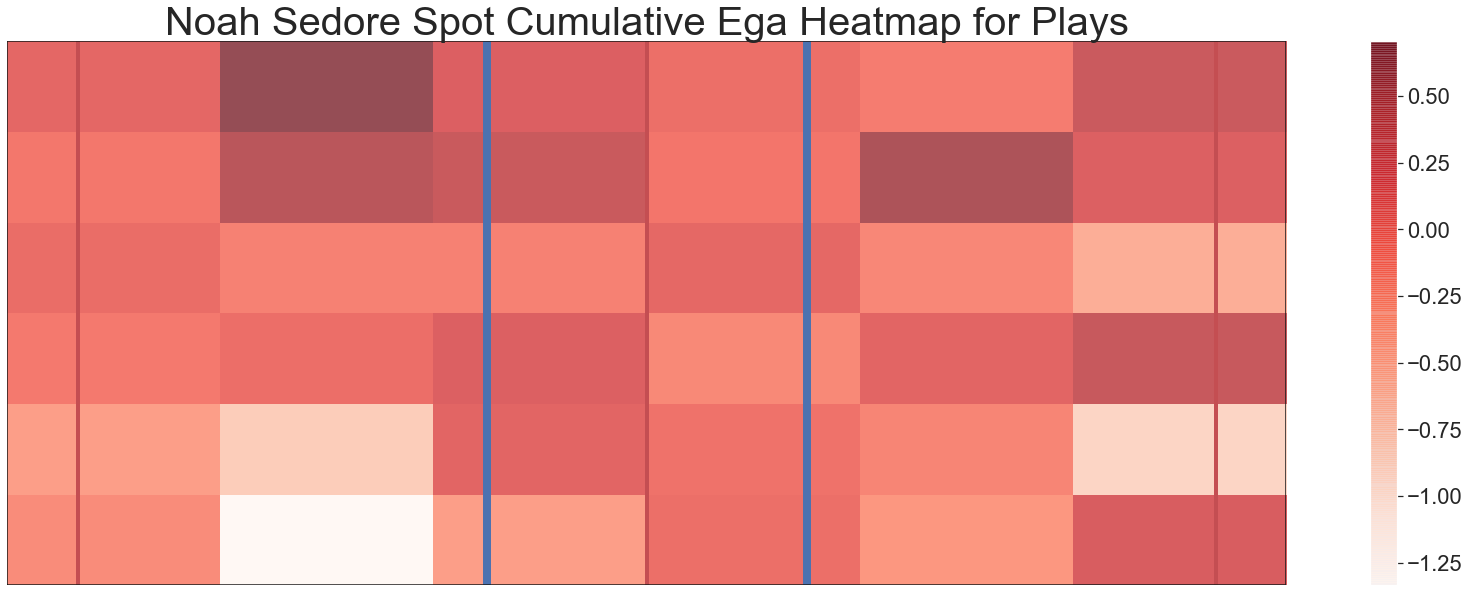

In [757]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_ylim(0, 85)
ax.set_xlim(0, 200)
ax.set_xlabel('', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.axvline(100, c='r', linewidth=4)
ax.axvline(75, c='b', linewidth=8)
ax.axvline(125, c='b', linewidth=8)
ax.axvline(11, c='r', linewidth=4)
ax.axvline(189, c='r', linewidth=4)
#ax.plot([11, 11], [39.5, 45.5], c='r', linewidth=4)
#ax.plot([189, 189], [39.5, 45.5], c='r', linewidth=4)
ax.plot([0, 200, 200, 0, 0], [0, 0, 85, 85, 0], c='k')
ax.grid(False)
im = ax.imshow(binnedAfterData.pivot('Y Coordinate', 'X Coordinate', 'EgaSum'), cmap='Reds', origin='lower', extent=[binnedAfterData['X Coordinate'].min(),200,0,85], alpha=0.7)
ax.set_title('Noah Sedore Spot Cumulative Ega Heatmap for Plays', fontsize=40)
plt.axis('off')
plt.colorbar(im, ax=ax)
plt.savefig('Noah Sedore Spot Cumulative Ega Heatmap for Plays', dpi=300)